In [48]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from typing import Tuple
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

We will be only catering to AOI : Rio for now.

ref : https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#writing-a-custom-dataset-for-pennfudan

In [28]:
SATELLITE_IMAGES_PATH = 'data/AOI_1_rio/imgs'
MASKS_PATH = 'data/AOI_1_rio/masks'
IMG_SIZE = (438, 406) # width, height

In [79]:
# A `Dataset` should override `__len__` and `__getitem__`
class BuildingFootprintDataset(Dataset):
    def __init__(self, satellite_imgs_path:str, masks_path:str, img_size:Tuple[int,int], transforms=None) -> None:
        super().__init__()
        self.transforms = transforms
        assert os.path.isdir(masks_path)
        assert os.path.isdir(satellite_imgs_path)
        self.satellite_imgs_path = satellite_imgs_path
        self.masks_path = masks_path 
        self.img_size=img_size
        self.images = sorted(os.listdir(satellite_imgs_path), key=lambda x: int(x.split('.')[0]))
        self.image_masks = sorted(os.listdir(masks_path), key=lambda x: int(x.split('.')[0]))
    def __len__(self):
        return len(self.image_masks)
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.satellite_imgs_path, self.images[index])).convert("RGB").resize(self.img_size)
        # without nearest resampling, adds more unique values than present with bicubic interpolation
        mask = Image.open(os.path.join(self.masks_path, self.image_masks[index])).resize(self.img_size, resample=Image.Resampling.NEAREST)
        # split mask into many masks, one per instance
        # each instance has a different color, as defined in the mask creation process from the raster files
        mask_np = np.array(mask)
        obj_ids = np.sort(np.unique(mask_np))[1:]
        masks = mask_np==obj_ids[:,None,None] 
        return img,masks
        
    

6940


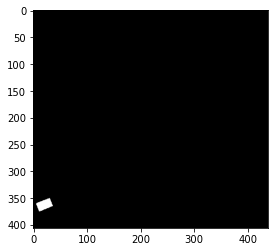

In [80]:
dataset = BuildingFootprintDataset(SATELLITE_IMAGES_PATH,MASKS_PATH, IMG_SIZE)
print(len(dataset))
img, masks = dataset[6939]
plt.imshow(masks[5],cmap='gray')

In [17]:
model = smp.Unet(
    encoder_name="resnet34",     
    encoder_weights="imagenet",  
    in_channels=3,               
    classes=1,                   
)

In [20]:
preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet')

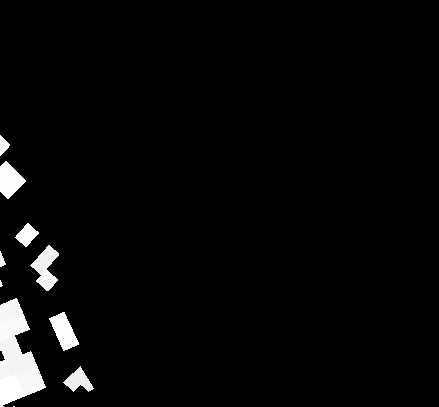

In [66]:
img = Image.open(f'{MASKS_PATH}/6940.png')
img

In [70]:
len(np.unique(img))

19

In [73]:
len(np.unique(img.resize(IMG_SIZE, resample=Image.Resampling.NEAREST)))

19

In [65]:
len(np.sort(np.unique(np.array(img))))

195

In [14]:
torch.Tensor(np.array(img)).shape

torch.Size([407, 439])